Engineer: Adeola Odunewu
Intern: FlipRobo LLC DS1123
Project: Rain Fall Weather Classification

In [1]:
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm

import matplotlib.pyplot as plt
from sklearn.svm import SVR, SVC
from statsmodels.formula.api import ols
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor

warnings.filterwarnings("ignore", message=".*deprecated.*")

In [2]:
# File paths for the CSV files
url = 'https://github.com/FlipRoboTechnologies/ML_-Datasets/raw/main/Rainfall%20Forecast/Rainfall.csv'

# Read CSV files into DataFrame objects
df = pd.read_csv(url)  

In [3]:
# Showing the first 5 column.
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
# Displaying Data Type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8425 entries, 0 to 8424
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           8425 non-null   object 
 1   Location       8425 non-null   object 
 2   MinTemp        8350 non-null   float64
 3   MaxTemp        8365 non-null   float64
 4   Rainfall       8185 non-null   float64
 5   Evaporation    4913 non-null   float64
 6   Sunshine       4431 non-null   float64
 7   WindGustDir    7434 non-null   object 
 8   WindGustSpeed  7434 non-null   float64
 9   WindDir9am     7596 non-null   object 
 10  WindDir3pm     8117 non-null   object 
 11  WindSpeed9am   8349 non-null   float64
 12  WindSpeed3pm   8318 non-null   float64
 13  Humidity9am    8366 non-null   float64
 14  Humidity3pm    8323 non-null   float64
 15  Pressure9am    7116 non-null   float64
 16  Pressure3pm    7113 non-null   float64
 17  Cloud9am       6004 non-null   float64
 18  Cloud3pm

In [3]:
# Identifying missing values
missing_data = df.isnull().sum()
print(missing_data)

Date                0
Location            0
MinTemp            75
MaxTemp            60
Rainfall          240
Evaporation      3512
Sunshine         3994
WindGustDir       991
WindGustSpeed     991
WindDir9am        829
WindDir3pm        308
WindSpeed9am       76
WindSpeed3pm      107
Humidity9am        59
Humidity3pm       102
Pressure9am      1309
Pressure3pm      1312
Cloud9am         2421
Cloud3pm         2455
Temp9am            56
Temp3pm            96
RainToday         240
RainTomorrow      239
dtype: int64


In [5]:
# Identify numerical columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Initialize SimpleImputer
imputer = SimpleImputer(strategy='median')

# Impute missing values in the original DataFrame
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

# Calculate the threshold for dropping columns with missing values greater than 20%
threshold = len(df) * 0.2  # 20% threshold

# Drop columns with missing values greater than 20%
df.dropna(thresh=threshold, axis=1, inplace=True)


In [6]:
# Get categorical columns
cate_columns = df.select_dtypes(include=['object']).columns

# Fill missing values with the mode of categorical columns using .loc to explicitly modify the DataFrame
for col in cate_columns:
    df[col].fillna(df[col].mode().iloc[0], inplace=True)


In [7]:
# Strip leading whitespace and convert the Rain-Tomorrow column to numeric values
df['RainTomorrow'] = df['RainTomorrow'].str.strip().replace({'No': 0, 'Yes': 1})

In [6]:
# Identifying missing values
missing_datak = df.isnull().sum()
print(missing_datak)

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


The decision above tackles missing values in integer columns of a DataFrame. Firstly, it identifies these columns and utilizes the median to impute missing values. To ensure dataset completeness, columns with over 20% missing values are dropped. This approach maintains a balance between data integrity and removing columns with substantial missing data. Additionally, categorical missing values are filled with column modes via explicit DataFrame modification using .loc. Lastly, the Rain-Tomorrow column is converted to numeric values (0,1).

In [18]:
# Selecting columns with object dtype (typically strings)
cate_df = df.select_dtypes(include=['object'])

# Selecting columns with numeric dtypes (integers and floats)
numeric_df = df.select_dtypes(include=['int64', 'float64'])

In [7]:
# Generate descriptive statistics for categorical columns
cate_df.describe()

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,8425,8425,7434,7596,8117,8185,8186
unique,3004,12,16,16,16,2,2
top,2011-01-31,Melbourne,N,N,SE,No,No
freq,5,1622,713,906,813,6195,6195


In [8]:
# Generate descriptive statistics for numerical columns
numeric_df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,8350.000000,8365.000000,8185.000000,4913.000000,4431.000000,7434.000000,8349.000000,8318.000000,8366.000000,8323.000000,7116.000000,7113.000000,6004.000000,5970.000000,8369.000000,8329.000000
mean,13.193305,23.859976,2.805913,5.389395,7.632205,40.174469,13.847646,18.533662,67.822496,51.249790,1017.640233,1015.236075,4.566622,4.503183,17.762015,22.442934
std,5.403596,6.136408,10.459379,5.044484,3.896235,14.665721,10.174579,9.766986,16.833283,18.423774,6.828699,6.766681,2.877658,2.731659,5.627035,5.980020
min,-2.000000,8.200000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,10.000000,6.000000,989.800000,982.900000,0.000000,0.000000,1.900000,7.300000
25%,9.200000,19.300000,0.000000,2.600000,4.750000,30.000000,6.000000,11.000000,56.000000,39.000000,1013.000000,1010.400000,1.000000,2.000000,13.800000,18.000000
50%,13.300000,23.300000,0.000000,4.600000,8.700000,39.000000,13.000000,19.000000,68.000000,51.000000,1017.700000,1015.300000,5.000000,5.000000,17.800000,21.900000
75%,17.400000,28.000000,1.000000,7.000000,10.700000,50.000000,20.000000,24.000000,80.000000,63.000000,1022.300000,1019.800000,7.000000,7.000000,21.900000,26.400000
max,28.500000,45.500000,371.000000,145.000000,13.900000,107.000000,63.000000,83.000000,100.000000,99.000000,1039.000000,1036.000000,8.000000,8.000000,39.400000,44.100000


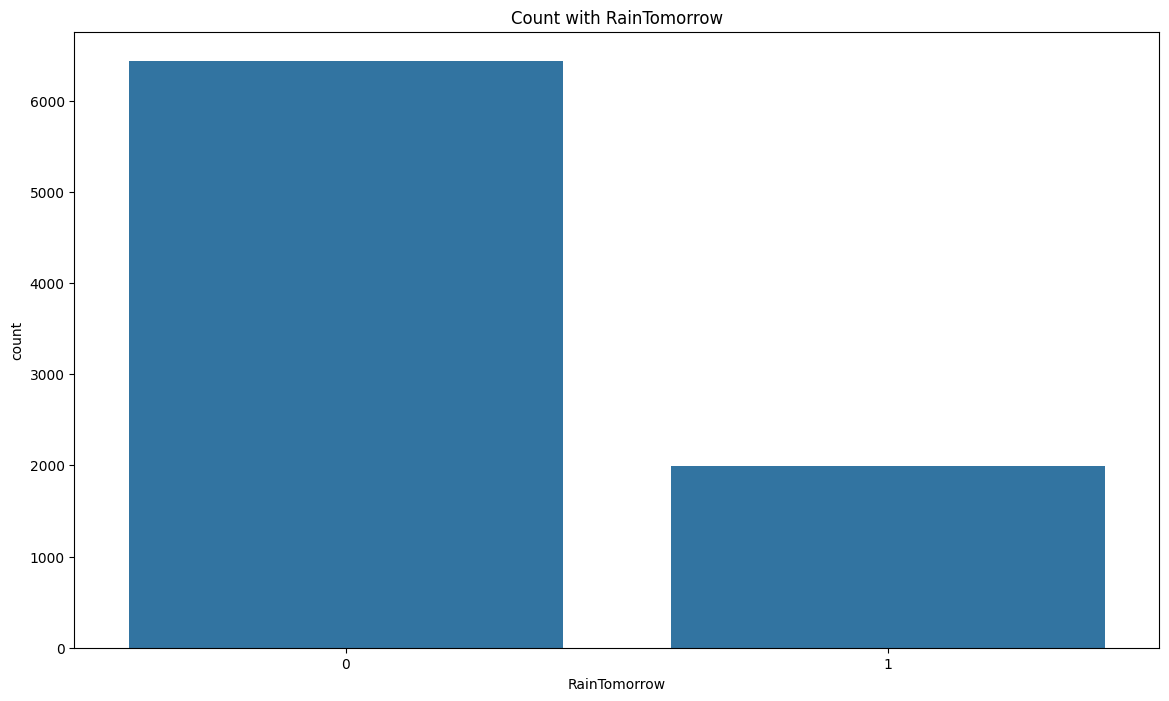

In [16]:
# Visualizing the distribution of RainTomorrow using a count plot 
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x= 'RainTomorrow')
plt.title("Count with RainTomorrow")
plt.show()

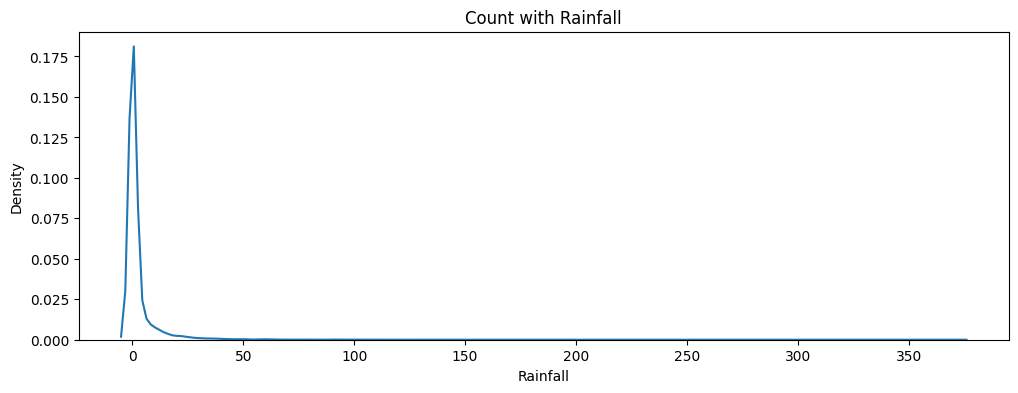

In [31]:
# Visualizing the distribution of Location using a count plot 
plt.figure(figsize=(12, 4))
sns.kdeplot(data=df, x= 'Rainfall')
plt.title("Count with Rainfall")
plt.show()

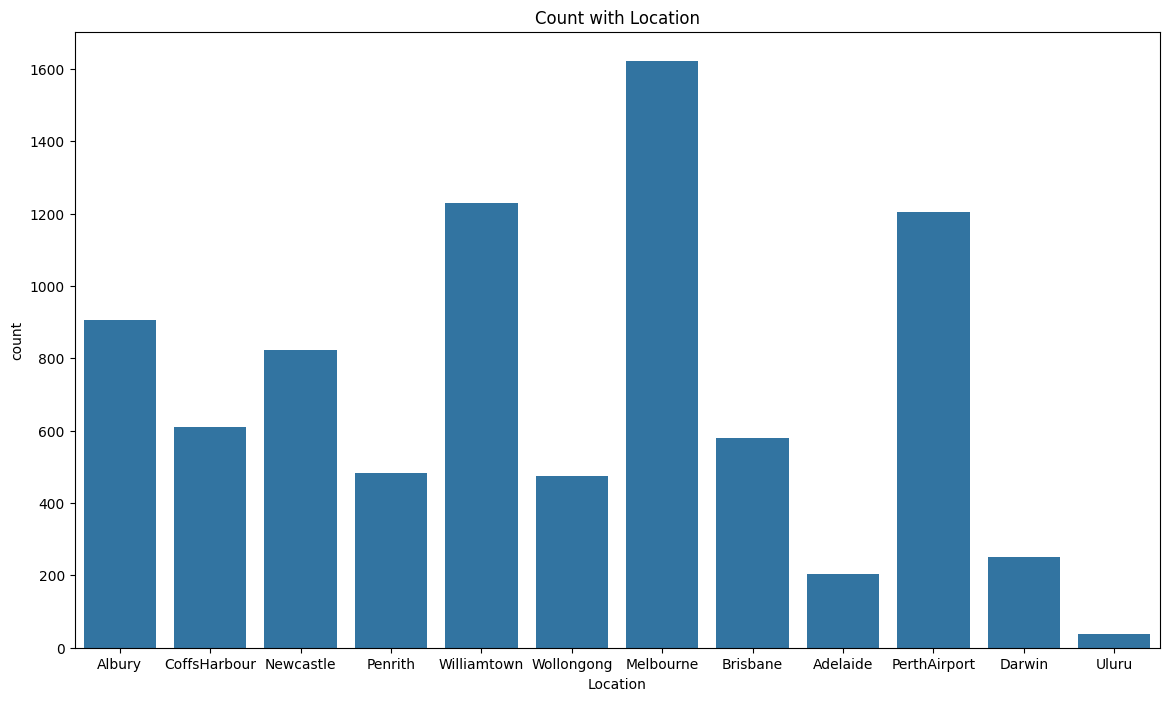

In [25]:
# Visualizing the distribution of Location using a count plot 
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x= 'Location')
plt.title("Count with Location")
plt.show()

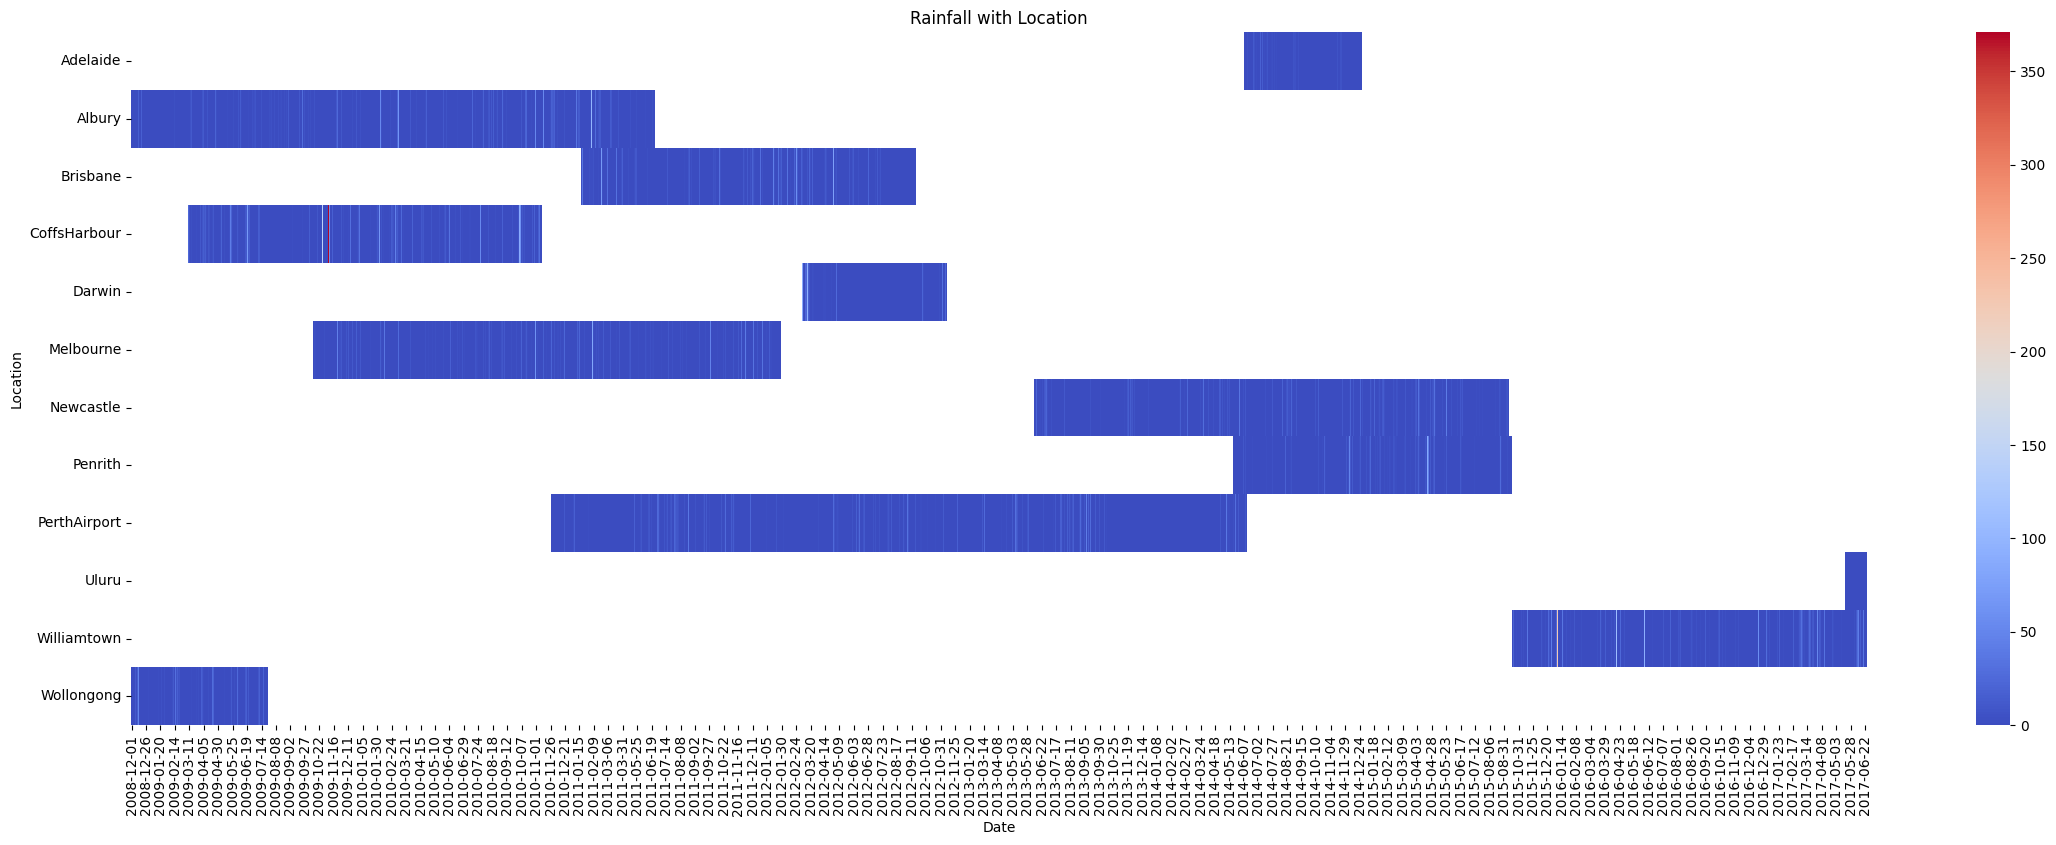

In [15]:
# Visualizing the heatmap of rainfall with Location using a boxplot
plt.figure(figsize=(28, 9))
sns.heatmap(data=df.pivot_table(index='Location', columns='Date', values='Rainfall'), cmap='coolwarm')
plt.title("Rainfall with Location")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

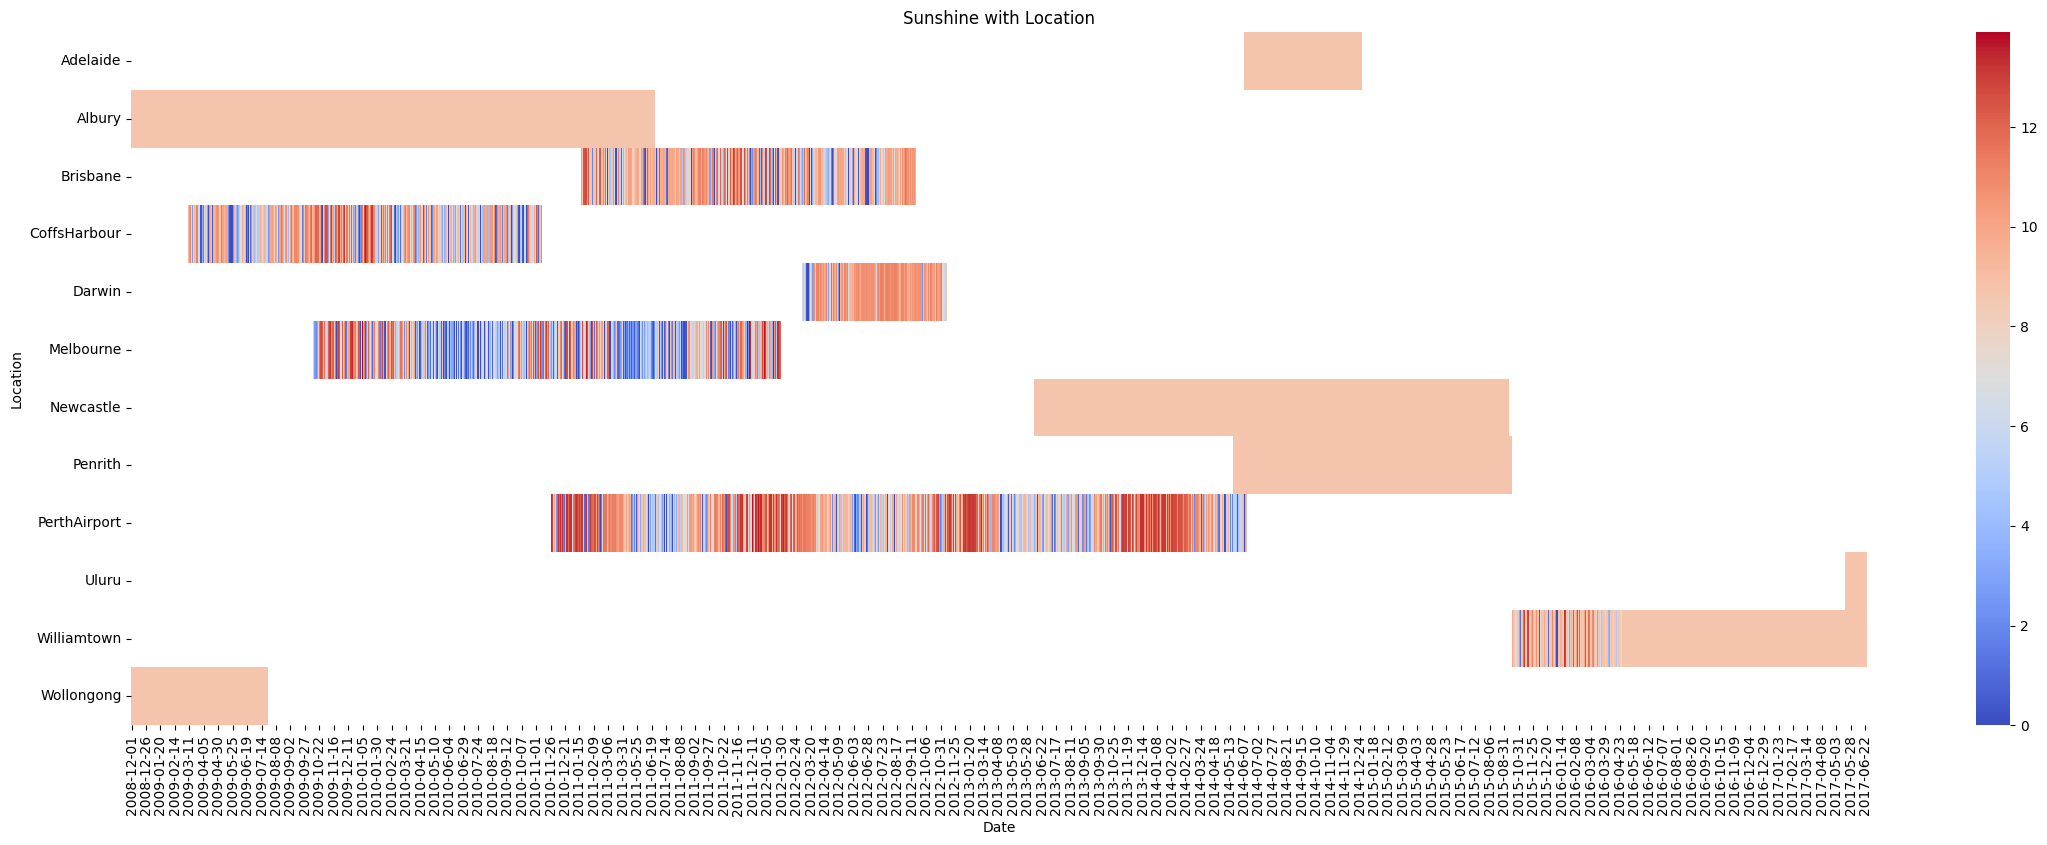

In [16]:
# Visualizing the heatmap of Sunshine with Location using a boxplot
plt.figure(figsize=(28, 9))
sns.heatmap(data=df.pivot_table(index='Location', columns='Date', values='Sunshine'), cmap='coolwarm')
plt.title("Sunshine with Location")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

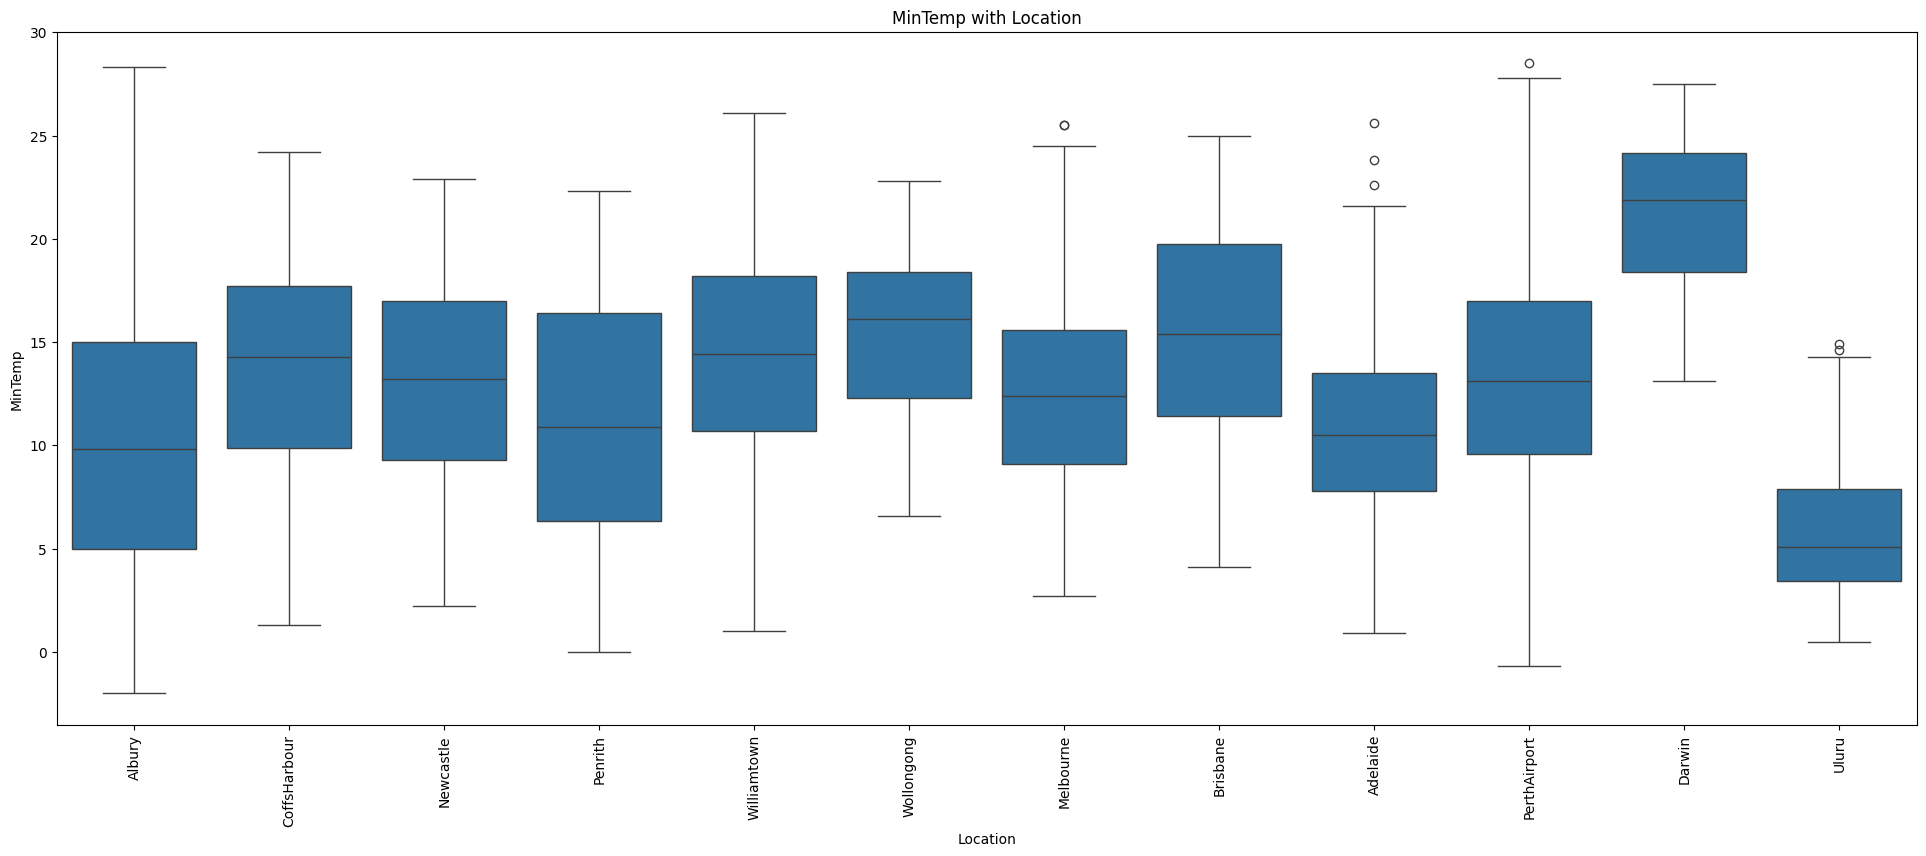

In [17]:
# Visualizing the distribution of MinTemp with Location using a boxplot
plt.figure(figsize=(24, 9))
sns.boxplot(data=df, x='Location', y='MinTemp')
plt.title("MinTemp with Location")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


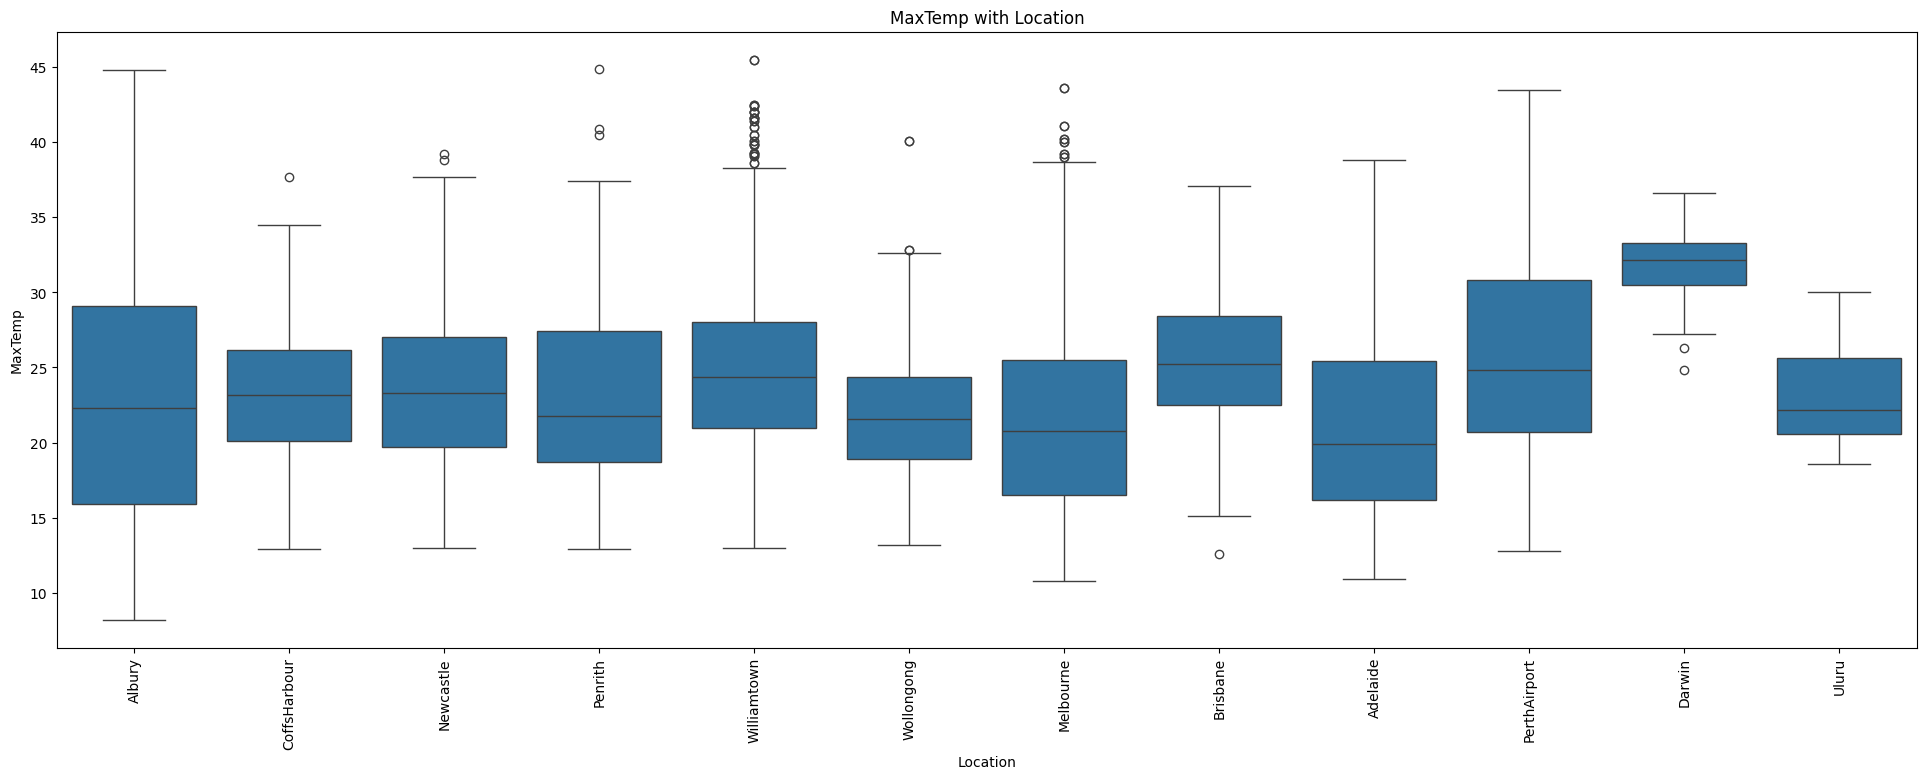

In [18]:
# Visualizing the distribution of MaxTemp with Location using a boxplot
plt.figure(figsize=(24, 8))
sns.boxplot(data=df, x='Location', y='MaxTemp')
plt.title("MaxTemp with Location")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

The first part visualizes the distribution of rainfall and Sunshine across different locations and dates using a heatmap, which helps in identifying 
patterns and anomalies in rainfall data.
    
The second part visualizes the distribution of maximum temperature across different locations using a boxplot, which helps in understanding 
the variability and central tendency of the temperature data for each location.

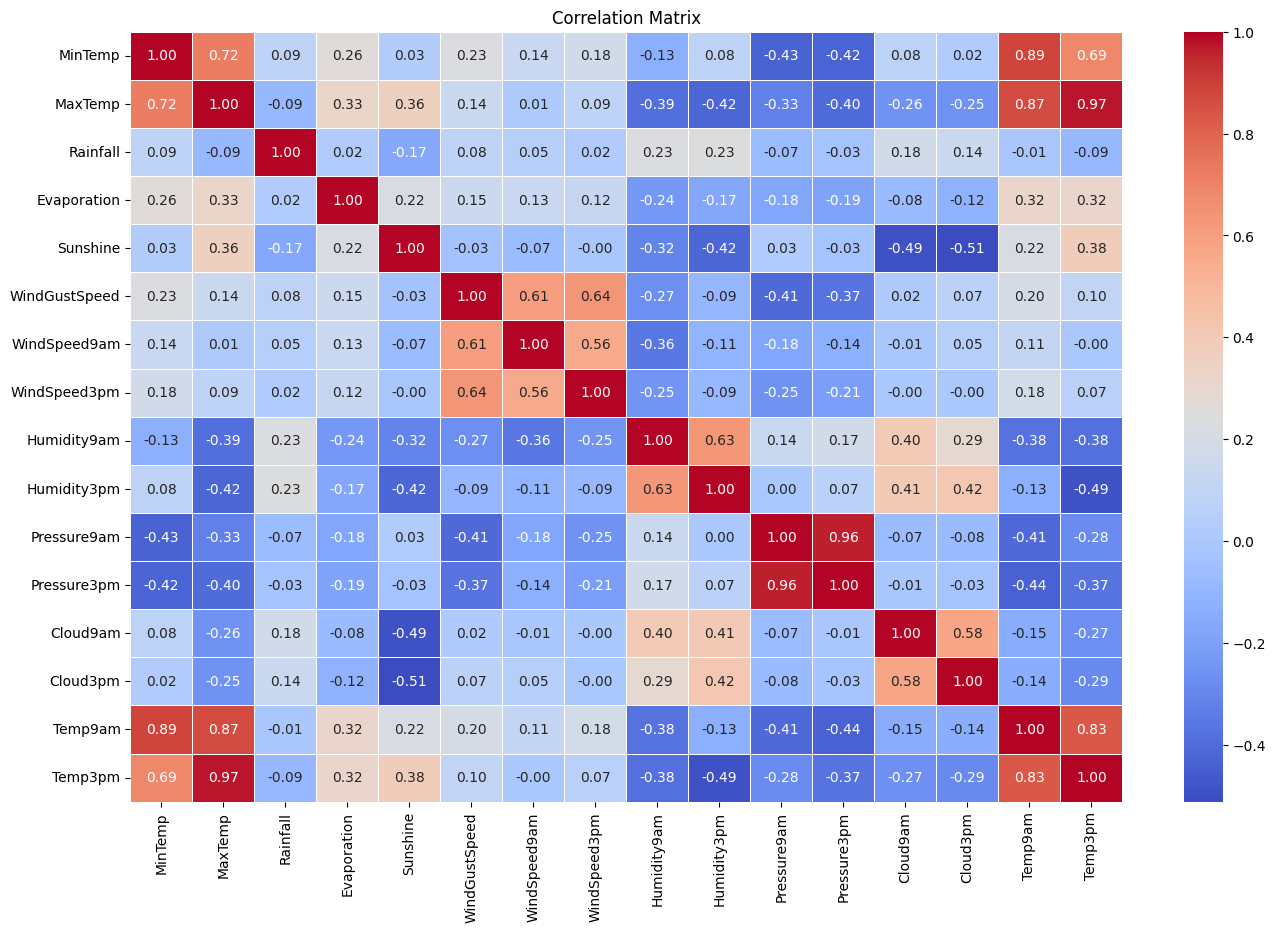

In [19]:
# Correlation Analysis for numeric_df is the DataFrame
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix including the target variable
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

The data shows a strong correlation of 0.72 between min temperature and max temperature, and an even stronger correlation of 0.83 with temperatures at 
3 PM and 9 PM. This indicates that temperatures at these specific times are good predictors of daily temperature ranges. Additionally, wind gust speed 
is correlated with wind speed at 9 PM (0.61), suggesting a link between gusty conditions and evening wind speeds. These insights are valuable for 
improving temperature and wind speed forecasting.

insight: 
The high correlation between daily temperature extremes and specific times (3 PM and 9 PM) can be used for more accurate temperature predictions 
and for understanding daily temperature patterns.
The correlation between wind gust speed and evening wind speed can help in forecasting and understanding wind behavior, which is crucial for activities 
affected by wind conditions, such as aviation and maritime operations.

Rows with outliers:
            Date      Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
12    2008-12-13        Albury     15.9     18.6      15.6          4.6   
44    2009-01-14        Albury     17.4     43.0       0.0          4.6   
52    2009-01-22        Albury     24.4     34.0       0.6          4.6   
60    2009-01-30        Albury     22.3     42.9       0.0          4.6   
61    2009-01-31        Albury     22.0     42.7       0.0          4.6   
...          ...           ...      ...      ...       ...          ...   
8100  2014-05-08  PerthAirport     12.5     19.1      37.4          0.8   
8136  2012-03-06        Darwin     23.7     32.7      91.0         10.6   
8144  2012-03-14        Darwin     24.1     29.8     142.2          4.6   
8145  2012-03-15        Darwin     23.3     29.2      96.8          6.6   
8185  2012-04-24        Darwin     23.4     32.6      40.0          7.4   

      Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
12    

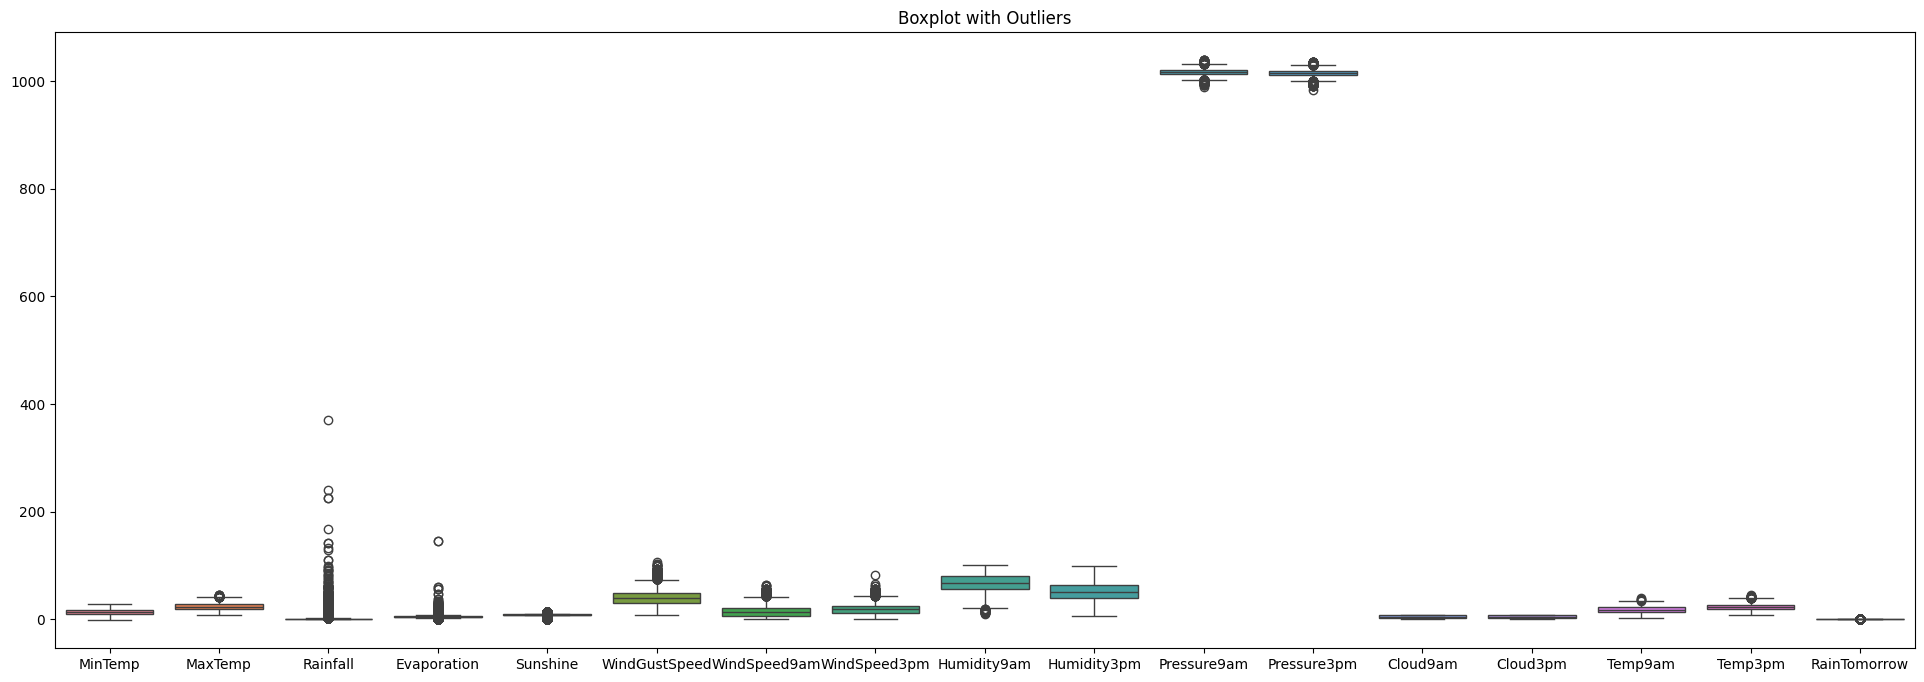

In [8]:
# Identifying Outliers

# Calculate z-scores for each data point
z_scores = ((numeric_df - numeric_df.mean()) / numeric_df.std()).abs()

# Define threshold for outliers (if z-score greater than 3)
outlier_threshold = 3

# Identify outliers using the z-score method
outlier_conditions = (z_scores > outlier_threshold)

# Display rows containing outliers
outliers = df[outlier_conditions.any(axis=1)]
print("Rows with outliers:")
print(outliers)

# Visualize the outliers using a boxplot
plt.figure(figsize=(24, 8))  
sns.boxplot(data=numeric_df) 
plt.title("Boxplot with Outliers")
plt.show()


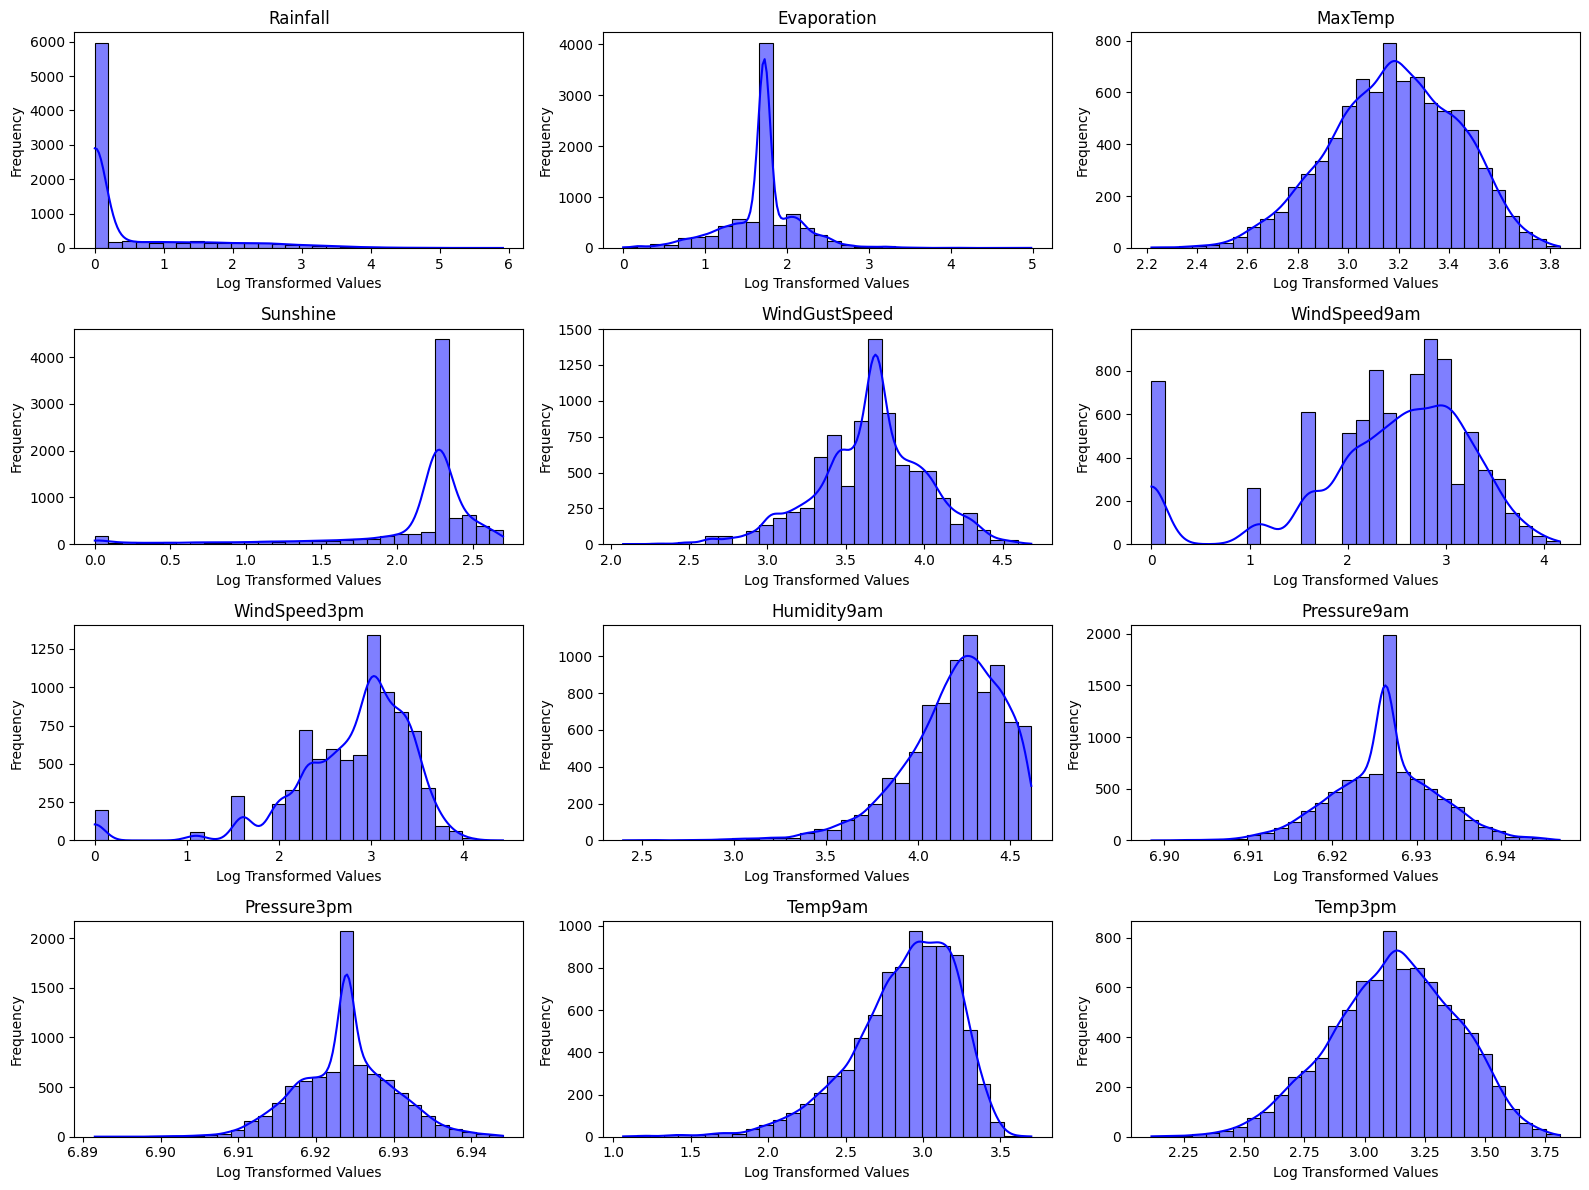

In [8]:
# Step 1: Identify Variables with Outliers
outlier_vars = ['Rainfall', 'Evaporation', 'MaxTemp', 'Sunshine', 'WindGustSpeed',
                'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Pressure9am', 
                'Pressure3pm', 'Temp9am', 'Temp3pm']

# Step 2: Apply Logarithmic Transformation
log_transformed_vars = df[outlier_vars].apply(lambda x: np.log(x + 1))  # Adding 1 to avoid log(0) issues

# Replace the original columns with the transformed columns
df[outlier_vars] = log_transformed_vars

# Visualize the transformed data
plt.figure(figsize=(16, 12))
for i, col in enumerate(outlier_vars):
    plt.subplot(4, 3, i+1)  # 4 rows, 3 columns
    sns.histplot(log_transformed_vars[col], bins=30, kde=True, color='blue')
    plt.title(col)
    plt.xlabel('Log Transformed Values')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

These techniques focus on identifying and transforming variables with outliers to reduce their impact. The logarithmic transformation is particularly 
effective in compressing the range of data, making extreme values less influential. Visualization of the transformed data is crucial for verifying the 
success of outlier mitigation.

In [11]:
# PCA Analysis
from sklearn.decomposition import PCA

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

# Perform PCA
pca = PCA()
pca.fit(scaled_data)

# Transform the data into the principal components
pca_data = pca.transform(scaled_data)

# Extracting explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# df_columns is a list of column names in the df1 DataFrame
df_columns = numeric_df.columns.tolist()

# Create a DataFrame to store the variable loadings for each principal component
loadings_df = pd.DataFrame(pca.components_, columns=df_columns)

# Print the variable loadings for each principal component
for i in range(loadings_df.shape[0]):
    print(f"Principal Component {i+1} Loadings:")
    print(loadings_df.iloc[i].sort_values(ascending=False))
    print()
# Create a DataFrame to examine the principal components
pca_df = pd.DataFrame(data=pca_data, columns=[f"PC{i+1}" for i in range(pca_data.shape[1])])

# Visualize the explained variance ratio
print("Explained Variance Ratio:", explained_variance_ratio)


Principal Component 1 Loadings:
MaxTemp          0.396433
Temp3pm          0.391867
Temp9am          0.377611
MinTemp          0.305165
Sunshine         0.199918
Evaporation      0.196260
WindGustSpeed    0.168747
WindSpeed3pm     0.144059
WindSpeed9am     0.116748
Rainfall        -0.054627
RainTomorrow    -0.090318
Cloud3pm        -0.164247
Cloud9am        -0.165789
Pressure9am     -0.230705
Humidity3pm     -0.231402
Pressure3pm     -0.254550
Humidity9am     -0.273952
Name: 0, dtype: float64

Principal Component 2 Loadings:
Cloud3pm         0.341371
RainTomorrow     0.335892
Cloud9am         0.331325
Humidity3pm      0.305314
WindGustSpeed    0.277518
MinTemp          0.233465
WindSpeed3pm     0.202346
Rainfall         0.200916
WindSpeed9am     0.186613
Humidity9am      0.152743
Temp9am          0.110992
Evaporation      0.014958
MaxTemp         -0.023806
Temp3pm         -0.059007
Pressure3pm     -0.280971
Sunshine        -0.311910
Pressure9am     -0.322239
Name: 1, dtype: float64

Pr

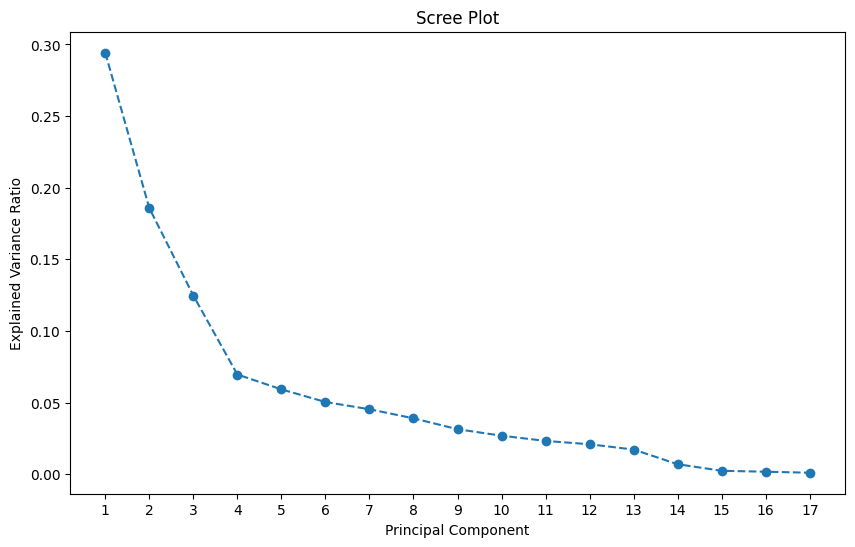

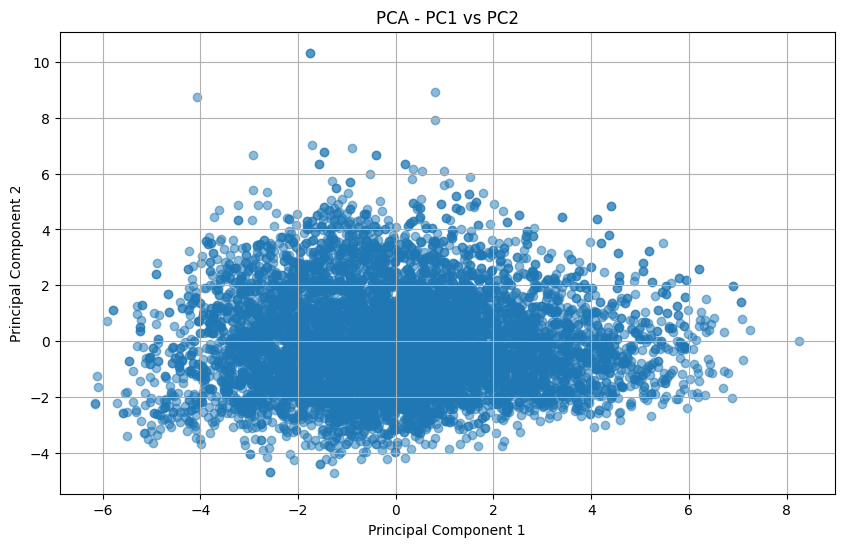

In [12]:
# Create a DataFrame to examine the principal components
pca_df = pd.DataFrame(data=pca_data, columns=[f"PC{i+1}" for i in range(pca_data.shape[1])])

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()

# Scatter plot of the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
plt.title('PCA - PC1 vs PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [11]:
#from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Variable"] = numeric_df.columns

# Calculate VIF for each predictor variable
vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(len(numeric_df.columns))]

# Print the VIF DataFrame
print(vif_data)

         Variable           VIF
0         MinTemp  4.565493e+01
1         MaxTemp  4.259141e+03
2        Rainfall  1.773892e+00
3     Evaporation  2.298366e+01
4        Sunshine  2.567961e+01
5   WindGustSpeed  1.994851e+02
6    WindSpeed9am  1.246813e+01
7    WindSpeed3pm  2.952918e+01
8     Humidity9am  7.190313e+02
9     Humidity3pm  4.110195e+01
10    Pressure9am  2.194479e+07
11    Pressure3pm  2.188159e+07
12       Cloud9am  8.551243e+00
13       Cloud3pm  8.794352e+00
14        Temp9am  7.786056e+02
15        Temp3pm  4.655341e+03
16   RainTomorrow  1.873966e+00


In [21]:
numeric_dfx = numeric_df.drop(columns=['RainTomorrow'])

In [23]:
# Set the random seed
np.random.seed(123)

# Display all warnings
warnings.simplefilter(action='always', category=UserWarning)

# Extract categorical features to be one-hot encoded
cate_dfx = df[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']]

# One-hot encode the categorical features
feature_columnsxc = pd.get_dummies(cate_dfx)

# Concatenate numeric and one-hot encoded categorical features
feature_columns = pd.concat([numeric_dfx, feature_columnsxc], axis=1)

# Define the target column
target_column = 'RainTomorrow'  # Replace 'RainTomorrow' with the actual name of your target column

# Separate the features (X) and the target (y)
Xi = feature_columns
yi = df[target_column]

# Split the data into training and testing sets
X_traini, X_testi, y_traini, y_testi = train_test_split(Xi, yi, test_size=0.3, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression(max_iter=1000)  # Increase max_iter if the model doesn't converge

# Catch warnings related to convergence
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter('always', category=ConvergenceWarning)
    
    try:
        model.fit(X_traini, y_traini)
    except Exception as e:
        warnings.warn(str(e))
    
    # Check for convergence warning
    if any(item.category == ConvergenceWarning for item in w):
        print("Warning: The model did not converge within the maximum number of iterations.")

# Make predictions on the test set
y_pred = model.predict(X_testi)

# Evaluate the model
accuracy = accuracy_score(y_testi, y_pred)
conf_matrix = confusion_matrix(y_testi, y_pred)
class_report = classification_report(y_testi, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Get feature importance
importance = model.coef_[0]
feature_names = feature_columns.columns

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort the DataFrame by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print("\nFeature Importance:\n", feature_importance)


Accuracy: 0.8429588607594937
Confusion Matrix:
 [[1843  100]
 [ 297  288]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90      1943
           1       0.74      0.49      0.59       585

    accuracy                           0.84      2528
   macro avg       0.80      0.72      0.75      2528
weighted avg       0.83      0.84      0.83      2528


Feature Importance:
                 Feature  Importance
5         WindGustSpeed    2.075617
23     Location_Penrith    1.154879
66       WindDir3pm_NNW    0.780577
18    Location_Brisbane    0.615092
16    Location_Adelaide    0.604266
..                  ...         ...
52         WindDir9am_S   -0.566490
20      Location_Darwin   -0.577599
27  Location_Wollongong   -0.905090
10          Pressure9am   -0.981253
11          Pressure3pm   -1.085487

[78 rows x 2 columns]


Variables to be modeled are chosen based on the following rationale: outliers were handled, multicollinearity was checked using VIF (Variance Inflation
Factor), PCA (Principal Component Analysis) was conducted to examine the principal components, and logistic regression was performed to identify
important features prior to modeling.

In [24]:
# Set the random seed
np.random.seed(123)

# Split the dataset into features (X) and the target variable (y)
X = df[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity3pm', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am']]  # Features (excluding categorical columns)
X_categorical = pd.get_dummies(df[['Location', 'WindDir3pm', 'RainToday', 'WindGustDir', 'WindDir9am']])  # One-hot encode categorical columns
X = pd.concat([X, X_categorical], axis=1)  # Combine numerical and encoded categorical features
y = df['RainTomorrow']
# Standardize features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Fit and transform the scaled features

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [25]:
# Checking for imbalance in the datasets.)
y.value_counts()			

RainTomorrow
0    6434
1    1991
Name: count, dtype: int64

In [26]:
# Initialize SMOTE ( to address the class imbalance in the datasets.)
sm = SMOTE()

# The implementation of the fit_resample 
X,y = sm.fit_resample(X,y)

# Create a DataFrame to see the distribution of classes in the target vector y
data = pd.concat([X, y], axis=1)
class_distribution = data[y.name].value_counts()

print(class_distribution)

RainTomorrow
0    6434
1    6434
Name: count, dtype: int64


In [27]:
# Set the random seed
np.random.seed(123)

# Suppress convergence warnings
warnings.filterwarnings("ignore", category = ConvergenceWarning)

# Define classifiers with names for clarity
classifiers = {
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=1000),  # Added max_iter to prevent convergence issues
    "SVM": SVC(),
    "XGBoost": xgb.XGBClassifier(reg_alpha=0.1, reg_lambda=0.1)  # Set regularization parameters
}

# Function to evaluate classifiers
def evaluate_classifier(clf, X, y):
    # Perform 10-fold cross-validation
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    # Return the mean and standard deviation of the scores
    return scores.mean(), scores.std()

# Evaluate and print results for each classifier
results = {name: evaluate_classifier(clf, X, y) for name, clf in classifiers.items()}

# Print the results
for name, (mean, std) in results.items():
    print(f"Classifier: {name}")
    print(f"Accuracy: {mean:.4f} +/- {std:.4f}")
    print("="*50)

Classifier: RandomForest
Accuracy: 0.8405 +/- 0.1554
Classifier: GradientBoosting
Accuracy: 0.7156 +/- 0.1598
Classifier: LogisticRegression
Accuracy: 0.7170 +/- 0.2012
Classifier: SVM
Accuracy: 0.7424 +/- 0.0540
Classifier: XGBoost
Accuracy: 0.8143 +/- 0.1688


For accuracy and  variability, RandomForest or XGBoost would be suitable choices.
For consistent and reliable performance with slightly lower accuracy, SVM is the best choice.
For moderate performance with higher variability, GradientBoosting and LogisticRegression could be considered,
but they might not be the top choices based on this analysis.

In [28]:
# Set the random seed for reproducibility
np.random.seed(123)

# Initialize RandomForest classifier
random_classifier = RandomForestClassifier()

# Define the parameter grid for RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [3, 4, 5],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=random_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found:")
print(grid_search.best_params_)

# Get the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy:.4f}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters found:
{'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy on Test Set: 0.8053


The RandomForest classifier, after hyperparameter tuning, achieved a test accuracy of 0.8053 with the specified parameters. This tuned model should 
generalize well to new data, given the robust cross-validation process used.

In [29]:
# Save the trained random forest model
joblib.dump(best_rf_model, 'Rainfall_classifier.joblib')

['Rainfall_classifier.joblib']

In [30]:
# Set the random seed
np.random.seed(123)

# Split the dataset into features (X) and the target variable (y)
X2 = df[['MinTemp', 'MaxTemp', 'Evaporation', 'Sunshine', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity3pm', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am']]  # Features (excluding categorical columns)
X_categorical2 = pd.get_dummies(df[['Location', 'WindDir3pm','RainTomorrow', 'RainToday', 'WindGustDir', 'WindDir9am']])  # One-hot encode categorical columns
X2 = pd.concat([X2, X_categorical2], axis=1)  # Combine numerical and encoded categorical features
y2 = df['Rainfall']
# Standardize features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X2)  # Fit and transform the scaled features

# Split the dataset into training (80%) and testing (20%) sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled, y2, test_size=0.2)

In [21]:
# Set the random seed
np.random.seed(123)

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define regression models with names for clarity
regressors = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "SVR": SVR(),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', reg_alpha=0.1, reg_lambda=0.1)  # Set regularization parameters
}

# Function to evaluate regressors
def evaluate_regressor(reg, X2, y2):
    # Perform 10-fold cross-validation
    scores_mse = cross_val_score(reg, X2, y2, cv=10, scoring='neg_mean_squared_error')
    scores_r2 = cross_val_score(reg, X2, y2, cv=10, scoring='r2')
    scores_mae = cross_val_score(reg, X2, y2, cv=10, scoring='neg_mean_absolute_error')
    
    # Compute mean and standard deviation of each metric
    mean_mse, std_mse = -scores_mse.mean(), scores_mse.std()
    mean_r2, std_r2 = scores_r2.mean(), scores_r2.std()
    mean_mae, std_mae = -scores_mae.mean(), scores_mae.std()
    
    return mean_mse, std_mse, mean_r2, std_r2, mean_mae, std_mae

# Assuming X and y are already defined
# Evaluate and print results for each regressor
results = {name: evaluate_regressor(reg, X2, y2) for name, reg in regressors.items()}

# Print the results
for name, (mean_mse, std_mse, mean_r2, std_r2, mean_mae, std_mae) in results.items():
    print(f"Regressor: {name}")
    print(f"Mean Squared Error: {mean_mse:.4f} +/- {std_mse:.4f}")
    print(f"R-squared (R²) Score: {mean_r2:.4f} +/- {std_r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mean_mae:.4f} +/- {std_mae:.4f}")
    print("="*50)


Regressor: LinearRegression
Mean Squared Error: 160278073648449280.0000 +/- 320665072763643712.0000
R-squared (R²) Score: -176321818085375808.0000 +/- 366361009754677056.0000
Mean Absolute Error (MAE): 128905379.1251 +/- 263938783.4020
Regressor: Ridge
Mean Squared Error: 0.1945 +/- 0.0429
R-squared (R²) Score: 0.7885 +/- 0.0169
Mean Absolute Error (MAE): 0.2493 +/- 0.0264
Regressor: Lasso
Mean Squared Error: 0.7942 +/- 0.1353
R-squared (R²) Score: 0.1307 +/- 0.0423
Mean Absolute Error (MAE): 0.6442 +/- 0.0867
Regressor: ElasticNet
Mean Squared Error: 0.7921 +/- 0.1337
R-squared (R²) Score: 0.1328 +/- 0.0448
Mean Absolute Error (MAE): 0.6429 +/- 0.0877
Regressor: RandomForest
Mean Squared Error: 0.1252 +/- 0.0749
R-squared (R²) Score: 0.8607 +/- 0.0761
Mean Absolute Error (MAE): 0.1685 +/- 0.0589
Regressor: GradientBoosting
Mean Squared Error: 0.1741 +/- 0.0377
R-squared (R²) Score: 0.8098 +/- 0.0178
Mean Absolute Error (MAE): 0.2165 +/- 0.0296
Regressor: SVR
Mean Squared Error: 0.3416

Best Performers: Random Forest and XGBoost exhibited the best performance with low MSE and MAE, and high R² scores.
Good Performers: Gradient Boosting and Ridge Regression also performed well.
Moderate Performers: SVR showed moderate performance.
Poor Performers: Linear Regression, Lasso, and ElasticNet did not perform well, with Linear Regression particularly struggling with extremely 
high error values and negative R², indicating it did worse than a horizontal line (mean prediction).

Further refine analysis will be consider:

Hyperparameter Tuning: Adjusting the hyperparameters of the Random Forest and XGBRegressor model should lead to improved performance.

In [33]:
# Set the random seed for reproducibility
np.random.seed(123)

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

random_forest = RandomForestRegressor(random_state=42)
xgboost = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the parameter grid for RandomForest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Define the parameter grid for XGBRegressor
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

# Perform GridSearchCV for RandomForestRegressor
grid_search_rf = GridSearchCV(estimator=random_forest, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train2, y_train2)

# Perform GridSearchCV for XGBRegressor
grid_search_xgb = GridSearchCV(estimator=xgboost, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train2, y_train2)

# Print the best parameters found for RandomForest
print("Best parameters for RandomForestRegressor found:")
print(grid_search_rf.best_params_)

# Print the best parameters found for XGBRegressor
print("Best parameters for XGBRegressor found:")
print(grid_search_xgb.best_params_)

# Get the best models from GridSearchCV
best_rf_model = grid_search_rf.best_estimator_
best_xgb_model = grid_search_xgb.best_estimator_

# Evaluate the best models on the test set
def evaluate_model(model, X_test2, y_test2):
    y_pred = model.predict(X_test2)
    mse = mean_squared_error(y_test2, y_pred)
    r2 = r2_score(y_test2, y_pred)
    mae = mean_absolute_error(y_test2, y_pred)
    return mse, r2, mae

# Evaluate RandomForestRegressor
mse_rf, r2_rf, mae_rf = evaluate_model(best_rf_model, X_test2, y_test2)
print(f"RandomForestRegressor Test Set Performance:")
print(f"Mean Squared Error: {mse_rf:.4f}")
print(f"R-squared (R²) Score: {r2_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
print("="*50)

# Evaluate XGBRegressor
mse_xgb, r2_xgb, mae_xgb = evaluate_model(best_xgb_model, X_test2, y_test2)
print(f"XGBRegressor Test Set Performance:")
print(f"Mean Squared Error: {mse_xgb:.4f}")
print(f"R-squared (R²) Score: {r2_xgb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.4f}")
print("="*50)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters for RandomForestRegressor found:
{'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best parameters for XGBRegressor found:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}
RandomForestRegressor Test Set Performance:
Mean Squared Error: 0.1713
R-squared (R²) Score: 0.8173
Mean Absolute Error (MAE): 0.2223
XGBRegressor Test Set Performance:
Mean Squared Error: 0.1300
R-squared (R²) Score: 0.8613
Mean Absolute Error (MAE): 0.1930


The XGBRegressor outperforms the RandomForestRegressor in terms of both error metrics (MSE and MAE) and the R-squared score, making it the preferable 
model for this particular regression problem.
Both models have been tuned effectively, but XGBRegressor shows better overall performance on the test set.

XGBRegressor Test Set Performance: Model Accuracy: With an R² score of 0.8613, your model is explaining a significant portion of the variance in 
the target variable, indicating good predictive accuracy.
Error Magnitude: Both MSE and MAE are relatively low, indicating that the predictions are close to the actual values.

In [34]:
# Save the trained random forest model
joblib.dump(best_rf_model, 'Rainfall_RFRegressor.joblib')


['Rainfall_RFRegressor.joblib']

In [35]:
# Save the trained random forest model
joblib.dump(best_xgb_model, 'Rainfall_XGBRegressor.joblib')

['Rainfall_XGBRegressor.joblib']

For rain/weather forecasting, the Random Forest and XGBoost models demonstrated superior performance in both classification and regression tasks,
with low error metrics and high R² scores. XGBRegressor outperformed RandomForestRegressor, making it the preferred choice for regression due to its 
better accuracy and lower errors. For classification, both RandomForestClassifier and XGBoostClassifier are highly suitable, with RandomForestClassifier
achieving a test accuracy of 0.8053 after hyperparameter tuning. Gradient Boosting and Ridge Regression also performed well, whereas SVR showed moderate
results. Linear Regression, Lasso, and ElasticNet struggled, particularly Linear Regression with high errors and negative R², indicating poor predictive
power.